In [36]:
# Imports
import numpy as np
import optuna
from hftbacktest import BacktestAsset, HashMapMarketDepthBacktest
from hftbacktest import Recorder
from hftbacktest.stats import LinearAssetRecord

from src.strategies import glft

# Data Input paths
preprocessed_data_path = "../data/daily_processed"
daily_eod_snapshots = "../data/snapshots" # EOD = End Of Day 

In [37]:
day_start = 22
day_end = 32
data = []
latencies = []

for i in range(day_start, day_end):
    day = str(i) if i > 9 else "0" + str(i)
    day_file = f"../data/daily_processed/deribit_eth_perp_2025-01-{day}.npz"
    day_latency = f"../data/latencies/latency_2025-01-{day}_latency.npz"
    data.append(day_file)
    # latencies.append(day_latency)
day_start_str = str(day_start - 1) if day_start > 10 else "0" + str(day_start - 1)
eod = np.load(f"../data/snapshots/deribit_eth_perp_2025-01-{day_start_str}_eod.npz")['data']

In [38]:

# Taken from https://support.deribit.com/hc/en-us/articles/25944746248989-Fees
MAKER_FEE = 0  
TAKER_FEE =  0.0005      


In [39]:
from src.strategies.glft import gridtrading_glft_mm

gamma = 0.09623412767966626
delta = 6
adj1 = 1.93155856130175
adj2 = 0.07016533681837103

max_position=50
asset = (
BacktestAsset()
    .data(data)
    .initial_snapshot(eod)
    .linear_asset(1.0)
    # .intp_order_latency(latencies, True)
    .constant_latency(10000, 10000) # Constant latency model (nanoseconds) values inspired from https://roq-trading.com/docs/blogs/2023-01-12/deribit/
    .risk_adverse_queue_model()
    # .power_prob_queue_model(2.0)
    .no_partial_fill_exchange()
    .trading_value_fee_model(MAKER_FEE, TAKER_FEE)
    .tick_size(0.01) # Tick size of this asset: minimum price increasement
    .lot_size(1) # Lot size of this asset: minimum trading unit
    # .roi_lb(0.0) # Sets the lower bound price for the range of interest in the market depth.
    # .roi_ub(3000.0) # Sets the upper bound price for the range of interest in the market depth.
    .last_trades_capacity(10000)
)

hbt = HashMapMarketDepthBacktest([asset])

n_trading_days = day_end - day_start
recorder = Recorder(1, n_trading_days* 1_000_000)

gridtrading_glft_mm(hbt, recorder.recorder, n_trading_days, gamma, delta, adj1, adj2, max_position)
hbt.close()

stats = LinearAssetRecord(recorder.get(0)).stats()
print(stats.summary(pretty=True)['Return'][0])


117.69499999999971


start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTradingValue,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-01-22 00:00:00,2025-01-31 23:59:50,2.90292,4.142562,117.695,174.25,0.100001,318.291684,0.675438,0.036978,3438.075


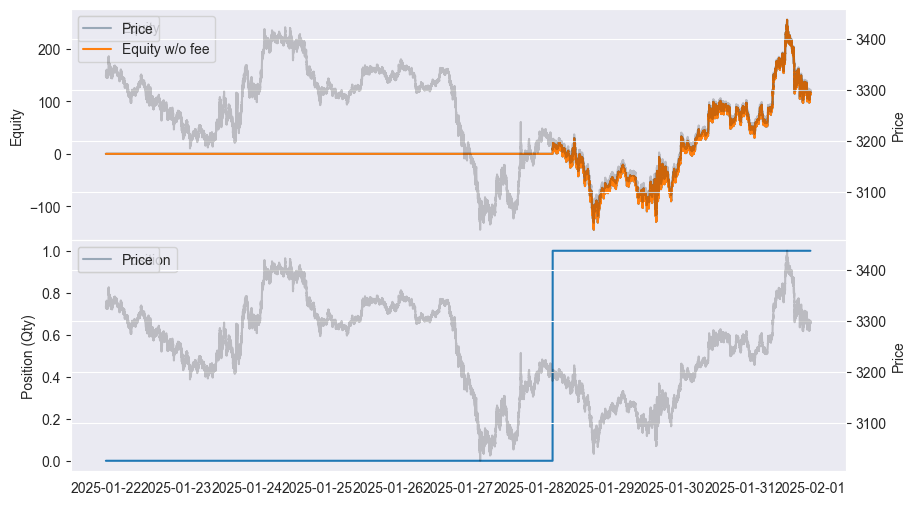

In [40]:
stats = LinearAssetRecord(recorder.get(0)).stats()
stats.plot()
stats.summary(pretty=True)